# test2p3.ipynb

A notebook to run only part3 of spinal_test2.ipynb .

Second test of the delegational learning rule in the context of the spinal cord project.
The task is the same as in spinal_test1.ipynb, but the am_pm_oscillator model is used.

Let $S_F, S_P, S_{P-F}, M_C$ denote the regions of the cortical model, and $s_F, s_P, s_{P-F}, m_C$ denote their current activities.
Assume that each unit $u_j$ in $M_C$ is associated with a vector $\bar{v}_j$, and that the ouput of the plant is $p = \sum_j u_j \bar{v}_j$. We also set $s_F = p$. The rule should be such that $p \approx s_P$.

The plant $P$ can be implemented as a population of linear units.
If the connection matrix from $M_C$ to $P$ is called $W$, then
$\bar{v}_j = (W_{1,j}, W_{2,j}, ..., W_{n,j})^T \equiv W_{:,j}$. 

# PART 3
Closed loop test of the `am_pm_oscillator` model for a multidimensional plant.

In [1]:
%cd ../..
from draculab import *
import numpy as np

import matplotlib.pyplot as plt
import time

/home/z/projects/draculab


In [2]:
def haar_matrix(dim):
    """ Returns an array with the normalized (2**dim x 2**dim) Haar matrix.
    
        Args:
            dim: an integer.
        Returns:
            A 2D numpy array of shape (2**dim, 2**dim), where each row is a
            Haar vector of norm 1.
    """
    # Obtain the matrix using the iterative procedure with Kronecker products
    h0 = np.array([1., 1.])
    h1 = np.array([1., -1.])
    haar = np.concatenate(([h0], [h1]))
    for d in range(1,dim):
        haar = np.concatenate((np.kron(haar, h0), 
                               np.kron(np.identity(2**d), h1)), axis=0)
    # Normalize the rows of the Haar matrix
    for idx, row in enumerate(haar):
        haar[idx, :] = row / np.linalg.norm(row)
    return haar

In [3]:
# Create the neuronal populations
N = 2 # size of each population
M__P_type = 'overcomplete' # type of M__P connections
M_type = "am2D" # "am_pm", "am", "am2D"

M__P_mats = {'identity' : 2.*np.eye(N),
               'haar' : haar_matrix(int(np.round(np.log(N)/np.log(2.)))),
               'overcomplete2' : np.random.random((N, 3*N))}
M__P_mats['overcomplete'] = np.concatenate((M__P_mats['identity'], M__P_mats['haar']), axis=1)
norms = np.linalg.norm(M__P_mats['overcomplete2'], axis=0)
M__P_mats['overcomplete2'] = M__P_mats['overcomplete2']/norms
W = M__P_mats[M__P_type]
M_N = W.shape[1]

des_pat = np.zeros(N) # desired pattern in SP
des_pats = np.random.random((2000, N)) # many desired patterns for SP
des_pat[np.arange(0,N,2)] = .9 # a 'one' every other entry
par_heter = 0.1 # range of heterogeneity as a fraction of the original value
randz = lambda : (1. + par_heter*(np.random.rand(N)-0.5))

net_params = {'min_delay' : 0.001,
              'min_buff_size' : 10 }
SF_params = {'type' : unit_types.sigmoidal,
             'thresh' : 0. * randz(),
             'slope' : 1. * randz(),
             'init_val' : 0.2 * randz(),
             'tau' : 0.05 }#* randz() }
SP_params = {'type' : unit_types.source,
             'init_val' : 0.5,
             'function' : lambda x: None }
SPF1_params = {'type' : unit_types.out_norm_sig,
              'thresh' : 0.5 * randz(),
              'slope' : 4. * randz(),
              'delay' : 0.3,
              'init_val' : 0.3 * randz(),
              'tau_fast': 0.005,
              'tau_mid': 0.05,
              'tau_slow' : 5.,
              'tau' : 0.05, #* randz(),
              'des_out_w_abs_sum' : 1. }
SPF2_params = SPF1_params
P_params = {'type' : unit_types.linear,
            'init_val' : 0.,
            'tau' : 0.05 }#* randz() }
if M_type == "am_pm":
    init_base = np.array([0.5, 0.5, 2.*np.pi, 0.5])
    M_params = {'type' : unit_types.am_pm_oscillator,
                'integ_meth' : 'odeint',
                'tau_u' : 0.1, #* randz(),
                'tau_c' : .2, #* randz(),
                'tau_t' : 1.,
                'tau_s' : 0.02,
                'init_val' : [(r+1.)*init_base for r in 0.2*(np.random.random(M_N)-0.5)],
                'multidim' : True,
                'omega' : 8.*np.pi,
                'F' : 'zero', #'input_sum',
                'custom_inp_del' : 300,
                'tau_fast': 0.005,
                'tau_mid' : 0.05,
                'tau_slow' : 1.,
                'delay' : 0.32,
                'mu' : 0.,
                'sigma' : 0.0 }
elif M_type == "am":
    init_base = np.array([0.5, 0.5, 0.5])
    M_params = {'type' : unit_types.am_oscillator,
                'integ_meth' : 'odeint',
                'tau_u' : 0.1,
                'tau_c' : .2,
                'tau_s' : 0.02,
                'init_val' : [(r+1.)*init_base for r in 0.2*(np.random.random(M_N)-0.5)],
                'multidim' : True,
                'omega' : 8.*np.pi,
                'custom_inp_del' : 300,
                'tau_fast': 0.005,
                'tau_mid' : 0.05,
                'tau_slow' : 1.,
                'delay' : 0.32,
                'mu' : 0.,
                'sigma' : 0.0 }
elif M_type == "am2D":
    init_base = np.array([0.5, 0.5])
    M_params = {'type' : unit_types.am_oscillator2D,
                'integ_meth' : 'odeint',
                'tau_u' : 0.1,
                'tau_c' : .2,
                'init_val' : [(r+1.)*init_base for r in 0.2*(np.random.random(M_N)-0.5)],
                'multidim' : True,
                'omega' : 8.*np.pi,
                'custom_inp_del' : 200,
                'tau_fast': 0.005,
                'tau_mid' : 0.05,
                'tau_slow' : 1.,
                'delay' : 0.24,
                'mu' : 0.,
                'sigma' : 0.0 }
    

def create_freqs_steps(n, w, r):
    """ Returns a 2-tuple with the lists required for heterogeneous frequencies.
    
        Args:
            n : number of units
            w : base angular (rad/s)
            r : amplitude of noise
        Returns
            2-tuple : (freqs, steps)
            freqs : a list with n angular frequencies.
            steps : a list with the corresponding delays. 
    """
    ws = w + r*(np.random.random(n) - 0.5)
    #ws = ws / M_params['tau_t'] # angular frequencies
    mp_del = np.arctan(P_params['tau']*ws)/ws
    psf_del = np.arctan(SF_params['tau']*ws)/ws
    sfspf_del = np.arctan(SPF1_params['tau']*ws)/ws
    spfm_del1 = np.arctan(M_params['tau_c']*ws)/ws
    spfm_del2 = np.arctan(M_params['tau_u']*ws)/ws
    d1 = mp_del + psf_del + sfspf_del + 4.*0.02
    del_steps = [int(d) for d in np.ceil(d1/net_params['min_delay'])]
    return (list(ws), del_steps)

om_var = 2. # increases omega frequency heterogeneity

# creating units
net = network(net_params)
SF = net.create(N, SF_params)
SP = net.create(N, SP_params)
SPF1 = net.create(N, SPF1_params)
SPF2 = net.create(N, SPF2_params)
P = net.create(N, P_params)

omegasE, del_stepsE = create_freqs_steps(M_N, M_params['omega'], om_var)
M_params['omega'] = omegasE
M_params['custom_inp_del'] = del_stepsE
ME = net.create(M_N, M_params)

omegasI, del_stepsI = create_freqs_steps(M_N, M_params['omega'], om_var)
M_params['omega'] = omegasI
M_params['custom_inp_del'] = del_stepsI
MI = net.create(M_N, M_params)

# set the pattern in SP
def make_fun(idx):
    #return lambda t: des_pat[idx]
    return lambda t: des_pats[int(round(t/15.)),idx]
for idx, u in enumerate(SP):
    net.units[u].set_function(make_fun(idx))

# Create the connections. See note on "detecting layer distances" in cortex wiki
SF__SPF1_conn = {'rule' : "one_to_one",
                 'delay' : 0.02 }
SF__SPF2_conn = SF__SPF1_conn
SF__SPF1_syn = {'type' : synapse_types.static,
               'init_w' : -1. }
SF__SPF2_syn = {'type' : synapse_types.static,
               'init_w' : 1. }
SP__SPF1_conn = {'rule' : "one_to_one",
                'delay' : 0.02 }
SP__SPF2_conn = SP__SPF1_conn
SP__SPF1_syn = {'type' : synapse_types.static,
               'init_w' : 1. }
SP__SPF2_syn = {'type' : synapse_types.static,
               'init_w' : -1. }
SPF1__ME_conn = {'rule': 'all_to_all',
                'delay': 0.02 }
SPF2__ME_conn = SPF1__ME_conn
SPF1__MI_conn = SPF1__ME_conn
SPF2__MI_conn = SPF1__ME_conn
SPF1__ME_syn = {'type' : synapse_types.rga,
                'lrate': 40.,
                #'post_delay': del_steps,
                'inp_ports': 0,
                'max_w' : 2.,
                'min_w' : 0.,
                'init_w' : {'distribution':'uniform', 'low':0.05, 'high':.1} }
SPF2__ME_syn = SPF1__ME_syn
SPF1__MI_syn = SPF1__ME_syn
SPF2__MI_syn = SPF1__ME_syn

# Specify the connection matrix from ME/MI to P
#W = 2.*np.eye(N)
#W = haar_matrix(3) # only for N = 2**dim

# connect ME/MI to P
ME__P_conn = {'rule': 'all_to_all',
              'delay': 0.02 }
ME__P_syn = {'type': synapse_types.static,
             'init_w' : W.flatten() }
MI__P_conn = ME__P_conn
MI__P_syn = {'type': synapse_types.static,
             'init_w' : -W.flatten() }
# From P to SF
P__SF_conn = {'rule' : 'one_to_one',
              'delay' : 0.02 }
P__SF_syn = {'type' : synapse_types.static,
             'init_w' : 3. }
# lateral connections in M
ME__ME_conn = {'rule': 'all_to_all',
               'allow_autapses' : False,
               'delay' : 0.02 }
ME__ME_syn = {'type' : synapse_types.static,
              'lrate' : 0.1,
              'inp_ports': 1,
              'init_w' : -0.1 }
ME__MI_conn = {'rule': 'one_to_one',
               'delay' : 0.02 }
ME__MI_syn = {'type' : synapse_types.static,
              'inp_ports': 1,
              'init_w' : -0.5 } # -0.5 }
MI__ME_conn = ME__MI_conn
MI__ME_syn = ME__MI_syn
MI__MI_conn = ME__ME_conn
MI__MI_syn = ME__ME_syn

net.connect(SF, SPF1, SF__SPF1_conn, SF__SPF1_syn)
net.connect(SF, SPF2, SF__SPF2_conn, SF__SPF2_syn)
net.connect(SP, SPF1, SP__SPF1_conn, SP__SPF1_syn)
net.connect(SP, SPF2, SP__SPF2_conn, SP__SPF2_syn)
net.connect(SPF1, ME, SPF1__ME_conn, SPF1__ME_syn)
net.connect(SPF1, MI, SPF1__MI_conn, SPF1__MI_syn)
net.connect(SPF2, ME, SPF2__ME_conn, SPF2__ME_syn)
net.connect(SPF2, MI, SPF2__MI_conn, SPF2__MI_syn)
net.connect(ME, P, ME__P_conn, ME__P_syn)
net.connect(MI, P, MI__P_conn, MI__P_syn)
net.connect(P, SF, P__SF_conn, P__SF_syn)
net.connect(ME, ME, ME__ME_conn, ME__ME_syn)
net.connect(MI, MI, MI__MI_conn, MI__MI_syn)
net.connect(ME, MI, ME__MI_conn, ME__MI_syn)
net.connect(MI, ME, MI__ME_conn, MI__ME_syn)
# extra ME-->MI connections to promote desynchronization
ME__MI_connX = {'rule': 'all_to_all',
               'delay' : 0.02 }
ME__MI_synX = {'type' : synapse_types.static,
              'inp_ports': 1,
              'init_w' : -.2/N }#-0.1 }
# this is to avoid duplicate connections
for idx, me in enumerate(ME):
    MI_reduced = MI[:idx] + MI[idx+1:]
    net.connect([me], MI_reduced, ME__MI_connX, ME__MI_synX)
    
# tracking state variables of the am_pm_oscillator
track_params = {'type' : unit_types.source,
                'init_val' : 0.02,
                'function' : lambda t: None }
def create_state_track(uid, var_id):
    return lambda t: net.units[uid].buffer[var_id,-1]
if M_type == "am":
    n_track = 3
elif M_type == "am2D":
    n_track = 2
elif M_type == "am_pm":
    n_track = 4
M_track = net.create(n_track, track_params)
for var in range(n_track):
    net.units[M_track[var]].set_function(create_state_track(ME[0],var))

In [8]:
sim_time = 40
start_time = time.time()
times, data, _  = net.flat_run(sim_time)
print('Execution time is %s seconds' % (time.time() - start_time))
data = np.array(data)

Execution time is 66.83985781669617 seconds


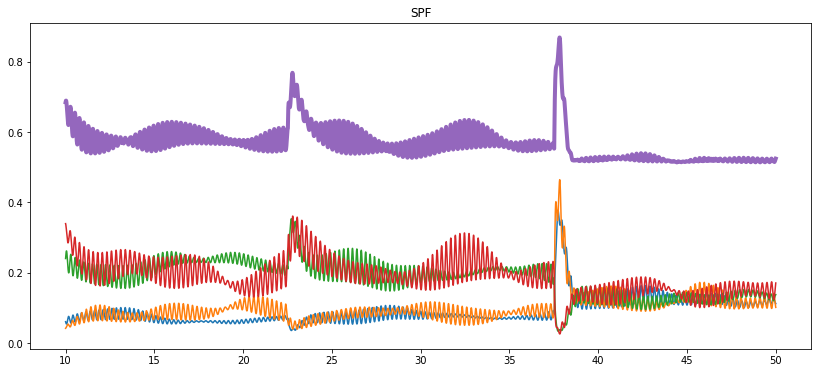

[0.11269979 0.10195278 0.13840878 0.17120616]


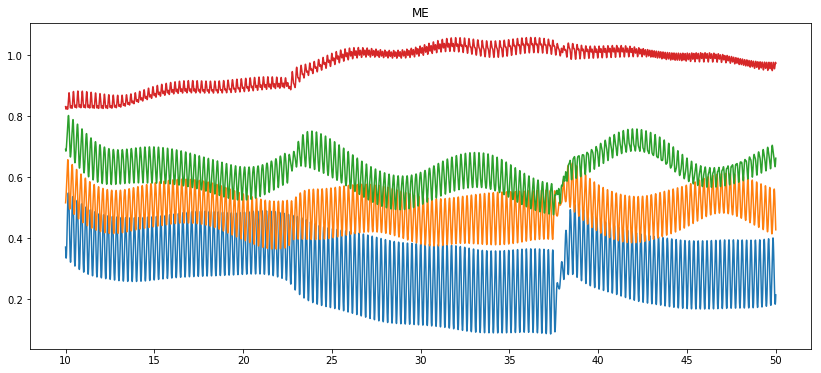

[0.21434204 0.42784213 0.66252508 0.97344999]


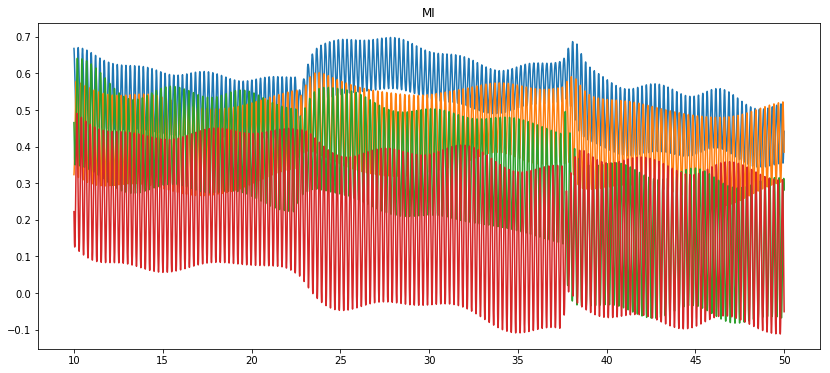

[ 0.44152952  0.38479253  0.28139329 -0.05116132]


In [9]:
fs = (14,6)
# SPF
SPF_fig = plt.figure(figsize=fs)
SPF_data = np.array(data[SPF1+SPF2])
plt.plot(times, SPF_data.transpose())
plt.plot(times, np.sum(SPF_data, axis=0), linewidth=4)
plt.title('SPF')
plt.show()
print(SPF_data[:,-1])

# M
ME_fig = plt.figure(figsize=fs)
ME_data = np.array(data[ME])
plt.plot(times, ME_data.transpose())
plt.title('ME')
plt.show()
print(ME_data[:,-1])

MI_fig = plt.figure(figsize=fs)
MI_data = np.array(data[MI])
plt.plot(times, MI_data.transpose())
plt.title('MI')
plt.show()
print(MI_data[:,-1])


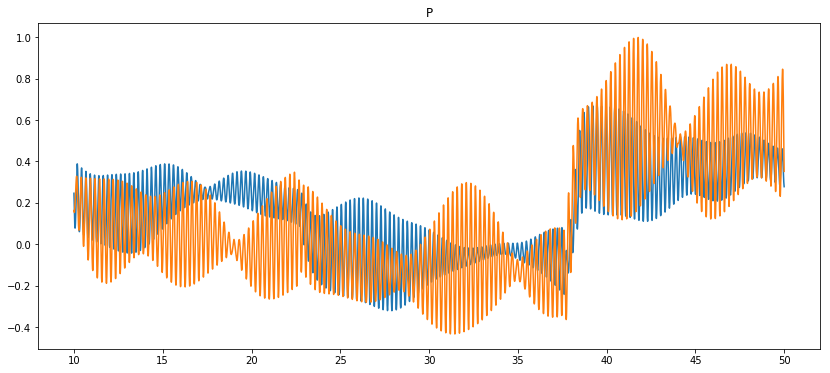

[0.27792293 0.3519232 ]


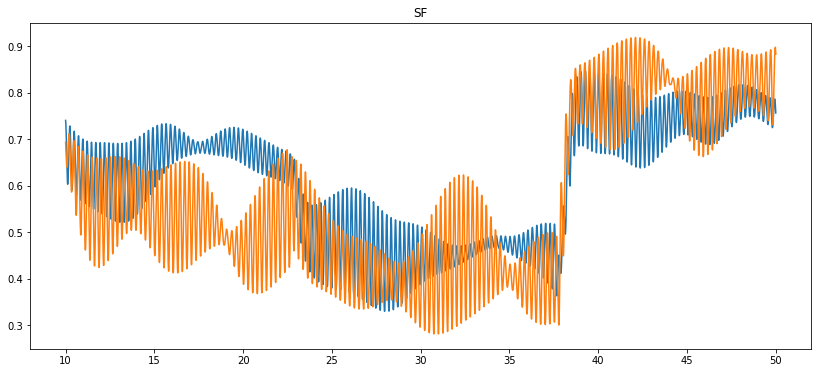

[0.75672357 0.88337517]
[0.74653342 0.78512746]


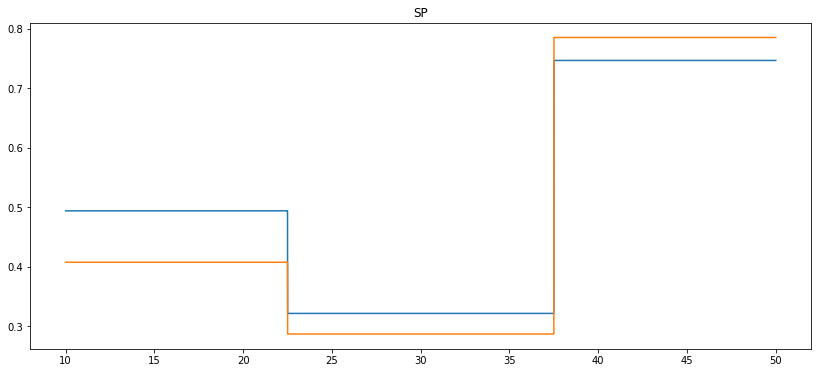

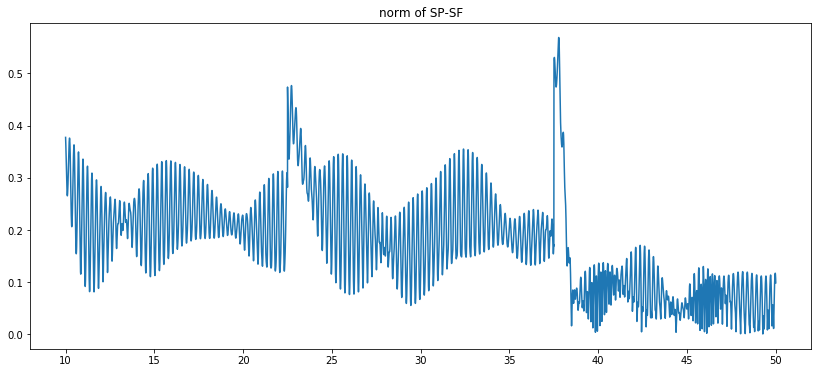

In [10]:
fs = (14,6)
# P
P_fig = plt.figure(figsize=fs)
P_data = np.array(data[P])
plt.plot(times, P_data.transpose())
plt.title('P')
plt.show()
print(P_data[:,-1])

# SF
SF_fig = plt.figure(figsize=fs)
SF_data = np.array(data[SF])
plt.plot(times, SF_data.transpose())
plt.title('SF')
plt.show()
print(SF_data[:,-1])

# SP
SP_fig = plt.figure(figsize=fs)
SP_data = np.array(data[SP])
plt.plot(times, SP_data.transpose())
plt.title('SP')
print(SP_data[:,-1])

# SP-SF
SP_SF = SP_data - SF_data
SP_SF_norm = np.linalg.norm(SP_SF, axis=0)
SP_SF_fig = plt.figure(figsize=fs)
plt.plot(times, SP_SF_norm)
plt.title('norm of SP-SF')
plt.show()


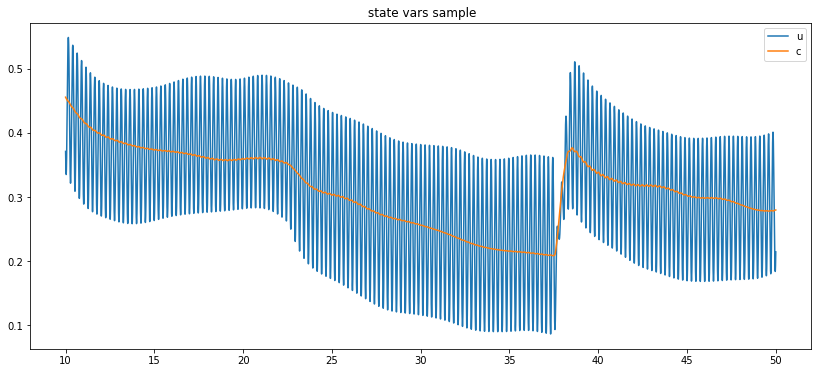

In [16]:
# state var trackers
M_track_fig = plt.figure(figsize=fs)
track_data = np.array(data[M_track])
plt.plot(times, data[M_track[0]])
plt.plot(times, data[M_track[1]])
if M_type == "am":
    plt.plot(times, data[M_track[2]])
elif M_type == "am_pm":
    plt.plot(times, data[M_track[3]])
if M_type == "am2D":
    plt.legend(['u','c'])
else:
    plt.legend(['u','c','I'])
#plt.plot(times, track_data.trose())
#plt.plot(times, data[ME[0],:],'r')
plt.title(' state vars sample')
plt.show()

In [11]:
for idx, syn in enumerate(net.syns[ME[1]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in SPF1:
        pre_pop = 'SPF1'
    elif pre_id in SPF2:
        pre_pop = 'SPF2'
    elif pre_id in MI:
        pre_pop = 'MI'
    elif pre_id in ME:
        pre_pop = 'ME'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d) --> ME, w=%f'%(idx, pre_pop, pre_id, syn.w))

0) SPF1 (4) --> ME, w=0.582519
1) SPF1 (5) --> ME, w=0.362939
2) SPF2 (6) --> ME, w=0.376239
3) SPF2 (7) --> ME, w=0.178311
4) ME (10) --> ME, w=-0.100000
5) ME (12) --> ME, w=-0.100000
6) ME (13) --> ME, w=-0.100000
7) MI (15) --> ME, w=-0.500000


In [12]:
for idx, syn in enumerate(net.syns[MI[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in SPF1:
        pre_pop = 'SPF1'
    elif pre_id in SPF2:
        pre_pop = 'SPF2'
    elif pre_id in MI:
        pre_pop = 'MI'
    elif pre_id in ME:
        pre_pop = 'ME'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d) --> MI, w=%f'%(idx, pre_pop, pre_id, syn.w))

0) SPF1 (4) --> MI, w=-0.004521
1) SPF1 (5) --> MI, w=0.488457
2) SPF2 (6) --> MI, w=0.868589
3) SPF2 (7) --> MI, w=0.138352
4) MI (15) --> MI, w=-0.100000
5) MI (16) --> MI, w=-0.100000
6) MI (17) --> MI, w=-0.100000
7) ME (10) --> MI, w=-0.500000
8) ME (11) --> MI, w=-0.100000
9) ME (12) --> MI, w=-0.100000
10) ME (13) --> MI, w=-0.100000


In [16]:
unit = net.units[ME[0]]
syns = unit.net.syns[unit.ID] 
pre_list_mp = []
for lst in unit.port_idx:
    pre_list_mp.append([syns[uid].preID for uid in lst])
print(pre_list_mp)
lists = []
lst1 = [[0,1], []]
for lst0 in lst1:
    lists.append([2*entry for entry in lst0])
[np.mean(l) if len(l) > 0. else 0. for l in lists]

[[16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], [41, 42, 43, 44, 45, 46, 47, 48]]


[1.0, 0.0]

In [11]:
for idx, syn in enumerate(net.syns[MI[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in SPF1:
        pre_pop = 'SPF1'
    elif pre_id in SPF2:
        pre_pop = 'SPF2'
    elif pre_id in MI:
        pre_pop = 'MI'
    elif pre_id in ME:
        pre_pop = 'ME'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d) --> MI, w=%f'%(idx, pre_pop, pre_id, syn.w))

0) SPF1 (16) --> MI, w=0.191650
1) SPF1 (17) --> MI, w=0.122293
2) SPF1 (18) --> MI, w=0.080965
3) SPF1 (19) --> MI, w=0.142586
4) SPF1 (20) --> MI, w=0.126662
5) SPF1 (21) --> MI, w=0.081977
6) SPF1 (22) --> MI, w=0.102542
7) SPF1 (23) --> MI, w=0.124371
8) SPF2 (24) --> MI, w=0.074692
9) SPF2 (25) --> MI, w=0.147417
10) SPF2 (26) --> MI, w=0.171079
11) SPF2 (27) --> MI, w=0.103356
12) SPF2 (28) --> MI, w=0.157364
13) SPF2 (29) --> MI, w=0.093548
14) SPF2 (30) --> MI, w=0.154888
15) SPF2 (31) --> MI, w=0.124610
16) MI (49) --> MI, w=-0.100000
17) MI (50) --> MI, w=-0.100000
18) MI (51) --> MI, w=-0.100000
19) MI (52) --> MI, w=-0.100000
20) MI (53) --> MI, w=-0.100000
21) MI (54) --> MI, w=-0.100000
22) MI (55) --> MI, w=-0.100000
23) ME (40) --> MI, w=-0.125000
24) ME (41) --> MI, w=-0.025000
25) ME (42) --> MI, w=-0.025000
26) ME (43) --> MI, w=-0.025000
27) ME (44) --> MI, w=-0.025000
28) ME (45) --> MI, w=-0.025000
29) ME (46) --> MI, w=-0.025000
30) ME (47) --> MI, w=-0.025000


In [12]:
print(net.units[0].buffer[:,-1])
print(net.units[1].buffer[:,-1])

IndexError: too many indices for array

In [ ]:
1. + 0.6068*np.sin(50.)